# Plan d'étude

A partir des données générales (1 an 10mois), nous allons réaliser une comparaison de deux modèles, kmeans et dbscan avec l'optimisation des paramètres. On évalura la performance de ces deux modèles en regardant les différentes métriques d'évaluation pour choisir le meilleur modèle ( silhouette, coude)
Par la suite on réalisera un radar plot sur le meilleur modèle et enfin une étude de stabilité avec deux datasets de 1 mois en utilisant adjusted_rand_score

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
from time import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_column', 47)

In [3]:
font_title = {"family": "Times New Roman",
              "color":  "blue",
              "weight": "bold",
              "size": 20}

In [4]:
df = pd.read_csv('customers-segmentation-general.csv')
df_ju = pd.read_csv('customers-segmentation-juillet.csv')
df_ao = pd.read_csv('customers-segmentation-aout.csv')

In [5]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [6]:
df.describe()

,nb_commandes,retard_livraisons_mean,temps_livraisons_mean,satisfaction_mean,review_score_mean,fdp_total,price_total,moyen_payment_mean,versement_payment_mean,Year,auto,autres,baby,bed_bath_table,computers_accessories,cool_stuff,electronics,furniture_decor,garden_tools,health_beauty,housewares,perfumery,sports_leisure,telephony,toys,watches_gifts,total_items,products_per_order_mean,mois_vente,order_total_delais
count,78188.000000,78188.000000,78188.000000,78188.000000,78188.000000,78188.000000,78188.000000,78188.000000,78188.000000,78188.000000,78188.000000,78188.000000,78188.000000,78188.000000,78188.000000,78188.000000,78188.000000,78188.000000,78188.000000,78188.000000,78188.000000,78188.000000,78188.000000,78188.000000,78188.000000,78188.000000,78188.000000,78188.000000,78188.000000,78188.000000
mean,1.030081,0.856395,13.076672,0.865674,4.124108,22.310818,128.029734,1.018400,2.880295,2017.482133,0.043242,0.229882,0.032588,0.126285,0.085525,0.045301,0.031616,0.090756,0.049381,0.100194,0.071392,0.038369,0.096549,0.051811,0.047885,0.062580,1.203356,1.166855,5.798562,207.626298
std,0.188061,5.081075,9.822353,0.339610,1.299569,15.148939,135.482115,0.125635,2.649658,0.499684,0.232398,0.524583,0.201386,0.431014,0.348484,0.235914,0.195942,0.390619,0.281514,0.350751,0.330367,0.223537,0.355551,0.261855,0.239444,0.276112,0.602354,0.539351,3.394228,136.552017
min,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.850000,1.000000,0.000000,2017.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,1.000000,0.000000,7.000000,1.000000,4.000000,14.100000,47.900000,1.000000,1.000000,2017.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,3.000000,95.000000
50%,1.000000,0.000000,11.000000,1.000000,5.000000,17.380000,89.800000,1.000000,2.000000,2017.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,5.000000,190.000000
75%,1.000000,0.000000,16.000000,1.000000,5.000000,25.630000,152.000000,1.000000,4.000000,2018.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,9.000000,307.000000
max,9.000000,189.000000,210.000000,1.000000,5.000000,110.820000,1098.000000,6.500000,24.000000,2018.000000,6.000000,12.000000,6.000000,9.000000,8.000000,12.000000,6.000000,11.000000,15.000000,6.000000,12.000000,7.000000,7.000000,14.000000,6.000000,8.000000,15.000000,15.000000,12.000000,542.000000


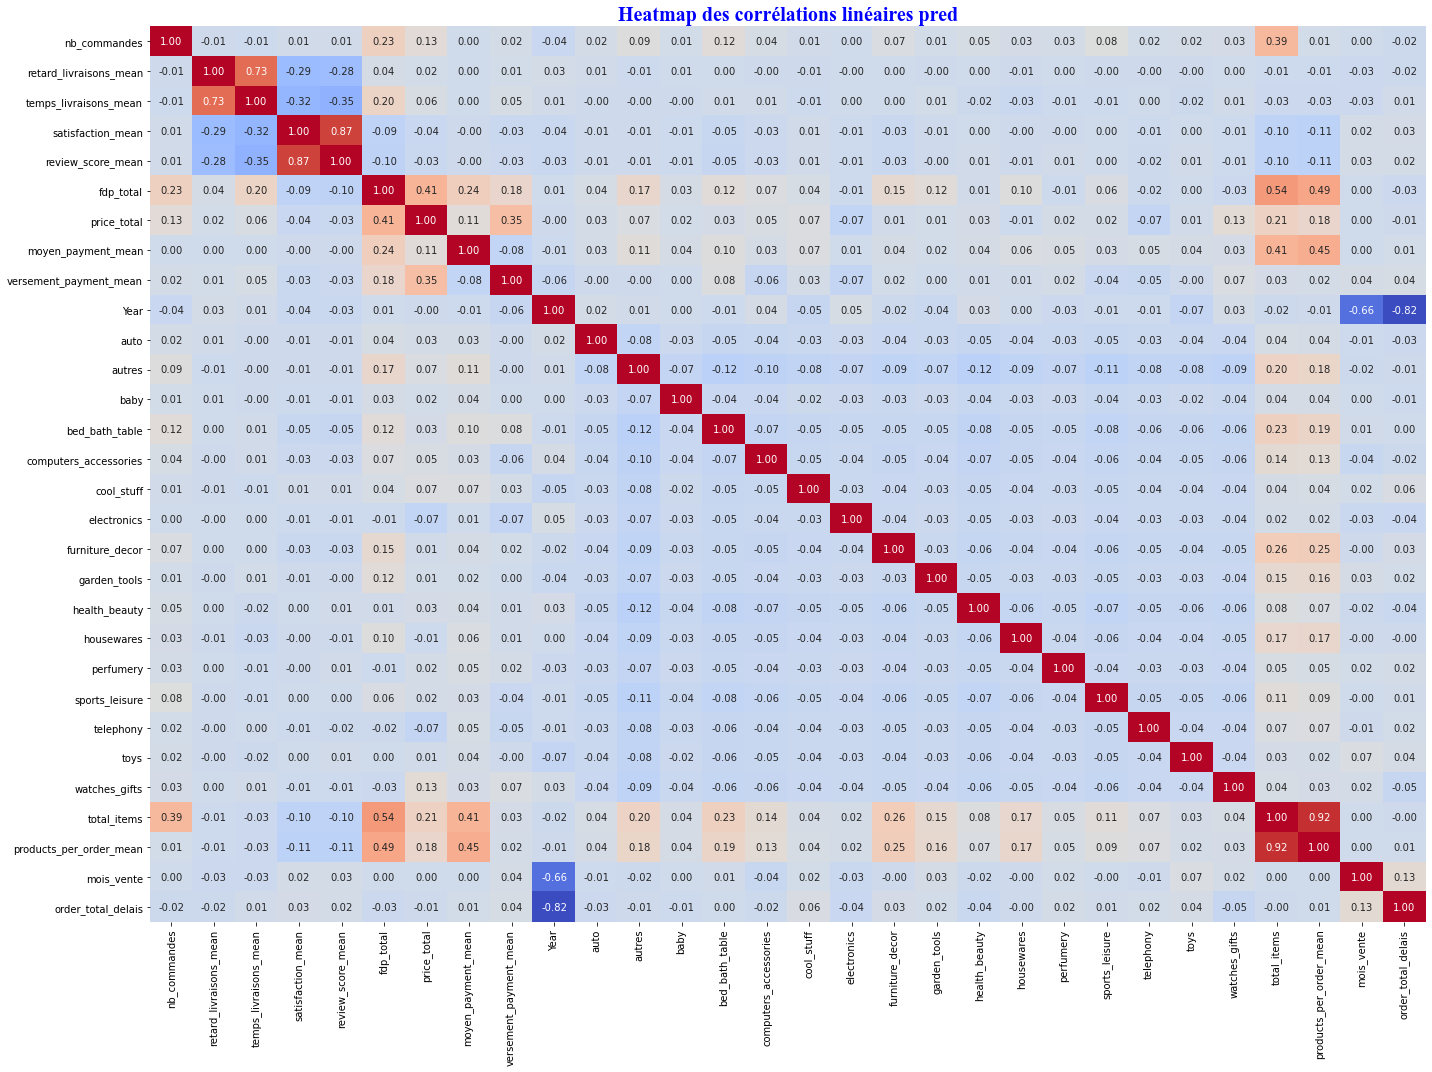

In [7]:
correlation = df.corr()
fig, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(correlation, annot=True, cbar=False,
            fmt=".2f", cmap="coolwarm", ax=ax)
plt.title("Heatmap des corrélations linéaires pred", fontdict=font_title)
plt.tight_layout()

In [8]:
df.drop(['review_score_mean', 'customer_unique_id', 'retard_livraisons_mean',
        'products_per_order_mean'], axis=1, inplace=True)

In [9]:
categorical_features = list(df.select_dtypes(
    exclude=['int64', 'float64', 'uint8']).columns)
categorical_features
categorical_features = df[categorical_features]
df.drop(categorical_features, axis=1, inplace=True)

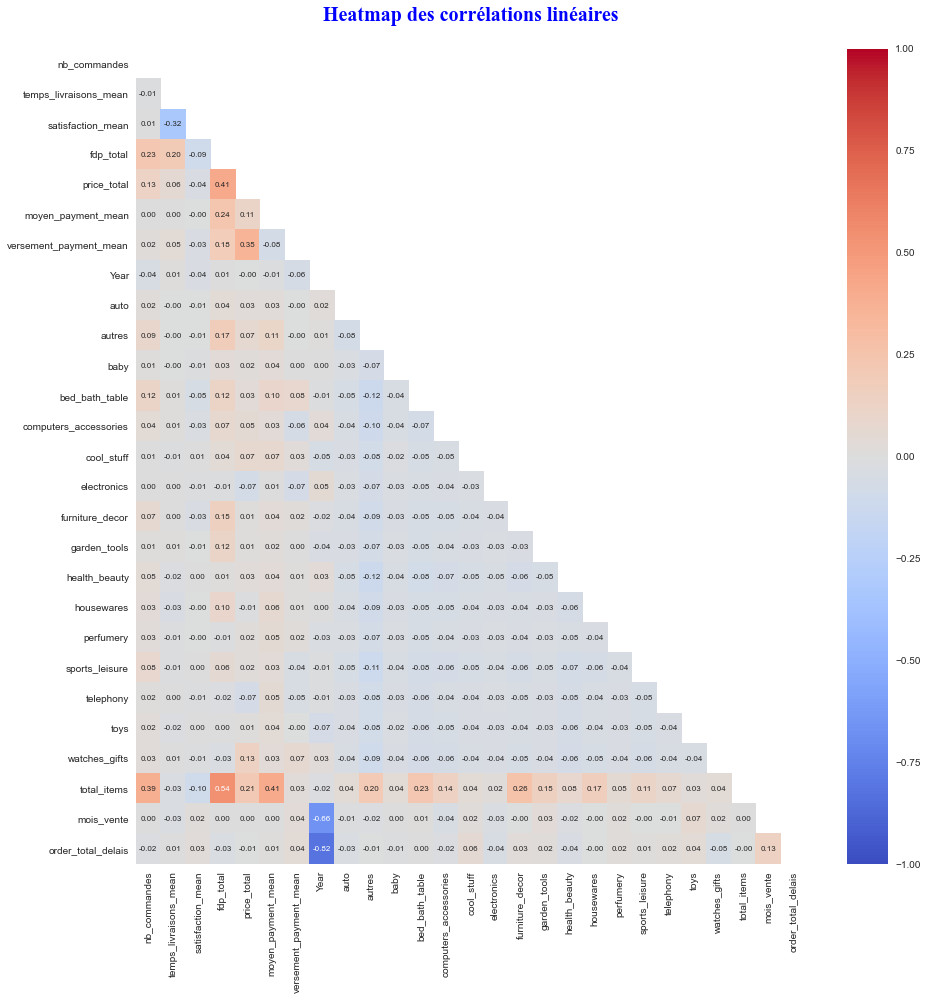

<Figure size 576x396 with 0 Axes>

In [90]:
corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(15, 15))
ax = sns.heatmap(corr, annot=True,
                 vmin=-1, vmax=1,
                 fmt=".2f", annot_kws={'size': 8},
                 mask=mask,
                 center=0,
                 cmap="coolwarm")
plt.title(f"Heatmap des corrélations linéaires\n",
          fontdict=font_title)
plt.show()
plt.savefig("Heatmap des corrélations linéaires.png") 

# Initialisation du machine learning

In [11]:
# preprocessing

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import model_selection
from scipy import stats
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

from sklearn import decomposition
from sklearn import preprocessing
from functions import *
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance

from sklearn.cluster import KMeans, SpectralClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score

from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.datasets import load_nfl

from sklearn.cluster import DBSCAN
from sklearn.metrics import adjusted_rand_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree
from sklearn.neighbors import NearestNeighbors
from sklearn import metrics

### Copies du dataframe principal

In [12]:
X = df.copy()
clustering = df.copy()
hierachique = df.copy()

### Preprocessing 

In [13]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

### Descente de coude

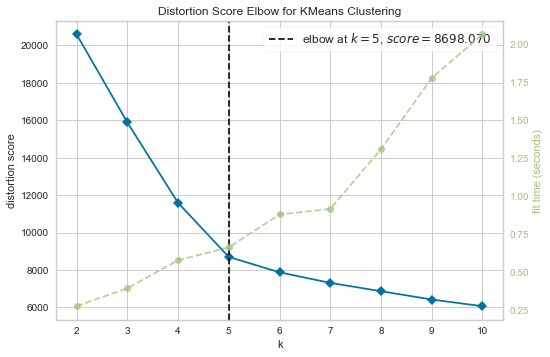

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [14]:
kmeans_visualizer = Pipeline([
    ("kelbowvisualizer", KElbowVisualizer(KMeans(init='k-means++'), K=(4, 12)))])
kmeans_visualizer.fit(X_scaled)
kmeans_visualizer.named_steps['kelbowvisualizer'].show()

Nous pouvons voir que sur le graphique de la descente de coude, il est préconisé de choisir 5 clusters pour notre modèle K-means ++

### Silhouette score 

Regardons maintenant le score obtenu du silhouette score en fonction de nos clusters 

In [15]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

n_clusters = range(2, 9)
scores = []
for n in n_clusters:

    kmeans = KMeans(n_clusters=n, init='k-means++', n_jobs=-1).fit(X_scaled)
    labs = kmeans.labels_
    score = silhouette_score(X_scaled, labs)
    scores.append(score)

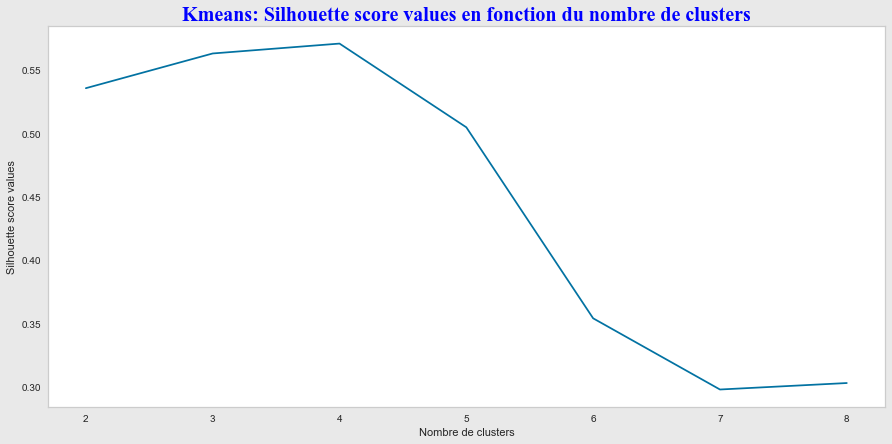

In [16]:
fig = plt.figure(figsize=[15, 7])
fig.patch.set_facecolor('#E0E0E0')
fig.patch.set_alpha(0.7)
plt.title("Kmeans: Silhouette score values en fonction du nombre de clusters",
          fontdict=font_title)

plt.plot(n_clusters, scores)
plt.ylabel("Silhouette score values")
plt.xlabel("Nombre de clusters")
plt.grid()

Le silhouette score le plus élévé est obtenu avec un nombre de clusters de 4 à 0.62, quant à 5 clusters 0.57. Celui de 6 clusters le silhouette score est de 0.41

#### Nous allons visualiser la taille des clusters avec le silhouette score pour 4, 5 et 6 clusters 

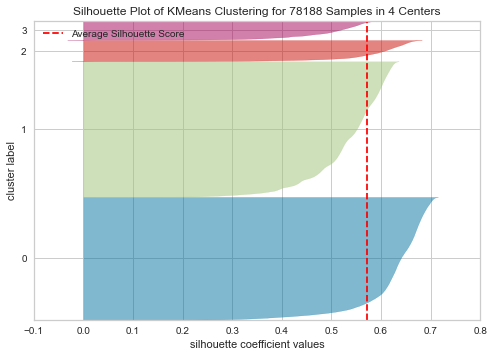

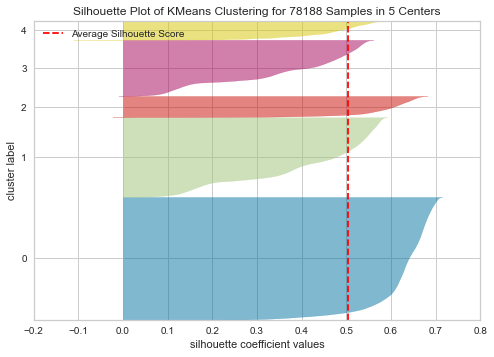

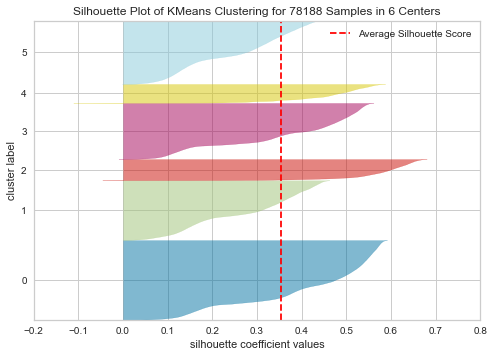

In [17]:
for n_cluster in range(4, 7):
    model = KMeans(n_cluster, init='k-means++', random_state=42)
    visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
    visualizer.fit(X_scaled)
    visualizer.show()

Pour 4 clusters les groupes sont asymétriques, pour 6 clusters les groupes sont homogène mais le silhouette score est assez faible de cette manière, nous allons choisir 5 clusters

### Le modèle 

In [18]:
Kmeans_model = Pipeline([("kmeans", KMeans(n_clusters=5,
                                           init='k-means++', random_state=42))])
Kmeans_model.fit(X_scaled)

clustering = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)
Kmeans_labels = Kmeans_model.named_steps['kmeans'].labels_
clustering['kmeans_cluster'] = Kmeans_labels
X['kmeans_cluster'] = Kmeans_labels

##### Regardons exactement la taille de chaque clusters

In [19]:
X_clust_sizes = clustering.groupby('kmeans_cluster').size().to_frame()
X_clust_sizes.columns = ["KM_size"]
X_clust_sizes

,KM_size
kmeans_cluster,
0,32139
1,20852
2,5558
3,14682
4,4957


In [20]:
silh_score = metrics.silhouette_score(
    clustering, Kmeans_labels, metric='euclidean')
print('Score de silhouette : %.3f' % silh_score)

Score de silhouette : 0.737


### TSNE

Réalisation de l'algorithme Tsne pour la visualisation de données grace à une réduction dimensionnelle

Pour se faire, nous allons réaliser un sample de notre dataset pour une question de cout-temps

In [21]:
sample = clustering.sample(frac=0.2, random_state=1)

target = sample['kmeans_cluster']

In [22]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=45, n_iter=1000)
tsne_results = tsne.fit_transform(sample)

[t-SNE] Computing 136 nearest neighbors...
[t-SNE] Indexed 15638 samples in 0.001s...
[t-SNE] Computed neighbors for 15638 samples in 6.416s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15638
[t-SNE] Computed conditional probabilities for sample 2000 / 15638
[t-SNE] Computed conditional probabilities for sample 3000 / 15638
[t-SNE] Computed conditional probabilities for sample 4000 / 15638
[t-SNE] Computed conditional probabilities for sample 5000 / 15638
[t-SNE] Computed conditional probabilities for sample 6000 / 15638
[t-SNE] Computed conditional probabilities for sample 7000 / 15638
[t-SNE] Computed conditional probabilities for sample 8000 / 15638
[t-SNE] Computed conditional probabilities for sample 9000 / 15638
[t-SNE] Computed conditional probabilities for sample 10000 / 15638
[t-SNE] Computed conditional probabilities for sample 11000 / 15638
[t-SNE] Computed conditional probabilities for sample 12000 / 15638
[t-SNE] Computed conditional probabilities for sa

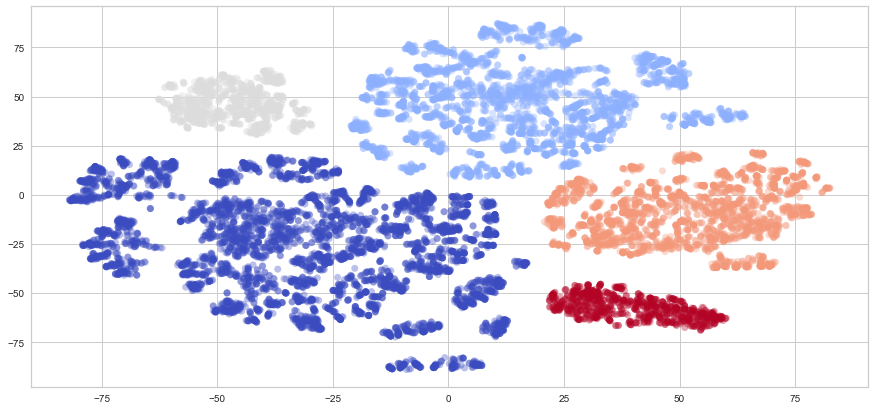

In [23]:
fig = plt.figure(figsize=[15, 7])
plt.scatter(tsne_results[:, 0], tsne_results[:, 1],  c=target,
            cmap="coolwarm", edgecolor="None", alpha=0.35)

Nous pouvons distinguer nos 5 clusters, bien délimité entre eux

# Comparaison avec DBSCAN

In [24]:
from sklearn.neighbors import NearestNeighbors
from sklearn import metrics

In [25]:
sample = hierachique.sample(frac=0.2, random_state=1)
dbs = scaler.transform(sample)

In [26]:
eps_list = np.arange(start=0.1, stop=0.8, step=0.1)
scores = []
for eps_trial in eps_list:
    db = DBSCAN(eps=eps_trial, min_samples=6).fit(dbs)
    labs = db.labels_
    score = silhouette_score(dbs, labs)
    scores.append(score)

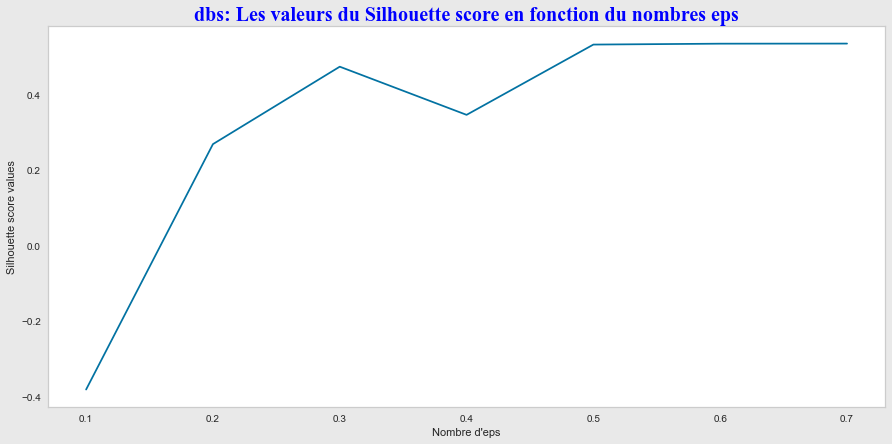

In [27]:
fig = plt.figure(figsize=[15, 7])
fig.patch.set_facecolor('#E0E0E0')
fig.patch.set_alpha(0.7)
plt.title("dbs: Les valeurs du Silhouette score en fonction du nombres eps",
          fontdict=font_title)

plt.plot(eps_list, scores)
plt.ylabel("Silhouette score values")
plt.xlabel("Nombre d'eps")
plt.grid()

In [83]:
clustering_dbscan = DBSCAN(eps=0.45, min_samples=6).fit(dbs)
labels_dbscan = clustering_dbscan.labels_
print("nombre d'observation dans les clusters :",
      pd.Series(labels_dbscan).value_counts())

nombre d'observation dans les clusters :  1    7527
 0    7031
 2     989
-1      91
dtype: int64


In [84]:
silh_score = metrics.silhouette_score(dbs, labels_dbscan, metric='euclidean')
print('Score de silhouette : ', silh_score)

Score de silhouette :  0.5311674633143689


In [85]:
dbs_clustering = pd.DataFrame(dbs, index=sample.index, columns=sample.columns)
dbs_clustering['cluster'] = pd.Categorical(labels_dbscan)
target_db = dbs_clustering['cluster']


dbscan_tsne = tsne.fit_transform(dbs_clustering)

[t-SNE] Computing 136 nearest neighbors...
[t-SNE] Indexed 15638 samples in 0.001s...
[t-SNE] Computed neighbors for 15638 samples in 7.249s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15638
[t-SNE] Computed conditional probabilities for sample 2000 / 15638
[t-SNE] Computed conditional probabilities for sample 3000 / 15638
[t-SNE] Computed conditional probabilities for sample 4000 / 15638
[t-SNE] Computed conditional probabilities for sample 5000 / 15638
[t-SNE] Computed conditional probabilities for sample 6000 / 15638
[t-SNE] Computed conditional probabilities for sample 7000 / 15638
[t-SNE] Computed conditional probabilities for sample 8000 / 15638
[t-SNE] Computed conditional probabilities for sample 9000 / 15638
[t-SNE] Computed conditional probabilities for sample 10000 / 15638
[t-SNE] Computed conditional probabilities for sample 11000 / 15638
[t-SNE] Computed conditional probabilities for sample 12000 / 15638
[t-SNE] Computed conditional probabilities for sa

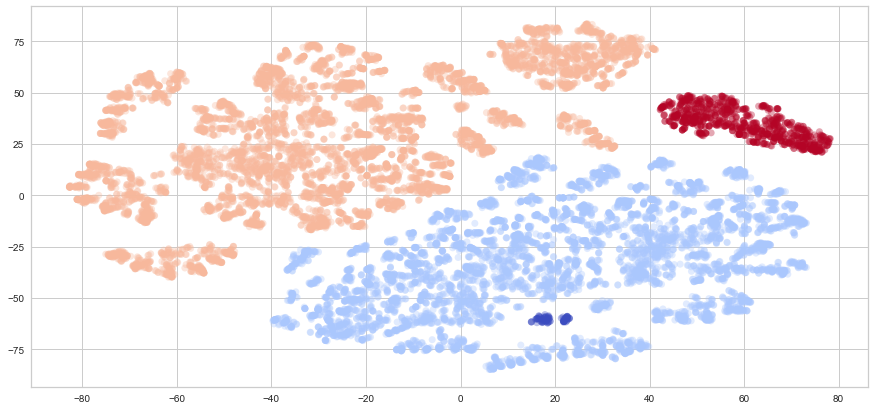

In [86]:
fig = plt.figure(figsize=[15, 7])
plt.scatter(dbscan_tsne[:, 0], dbscan_tsne[:, 1],  c=target_db,
            cmap="coolwarm", edgecolor="None", alpha=0.35)

le maximum obtenus avec DBSCAN est de 0.35 pour 3 clusters de cette manière, nous allons privilégé notre premier modèle Kmeans++

# Kmeans ++ radar chart

In [32]:
X_clustering = X.groupby("kmeans_cluster").mean()
features = list(X_clustering.select_dtypes(
    include=['int64', 'float64', 'int32']).columns)
preprocessor = ColumnTransformer([
    ('scaler', scaler, features)])

clusters_means = preprocessor.fit_transform(X_clustering)
clusters_means = pd.DataFrame(clusters_means,  columns=X_clustering.columns)

In [101]:
clusters_means

,nb_commandes,temps_livraisons_mean,satisfaction_mean,fdp_total,price_total,moyen_payment_mean,versement_payment_mean,Year,auto,autres,baby,bed_bath_table,computers_accessories,cool_stuff,electronics,furniture_decor,garden_tools,health_beauty,housewares,perfumery,sports_leisure,telephony,toys,watches_gifts,total_items,mois_vente,order_total_delais
0,0.000000,0.000000,1.000000,0.008080,0.000000,0.119191,0.000000,1.0,0.867063,0.684000,0.238131,0.000000,0.351782,0.000928,0.867365,0.000000,0.000000,1.000000,0.471662,0.000000,0.356864,0.000000,0.013668,0.691568,0.000000,0.049747,0.000000
1,0.941226,0.046416,0.998983,0.000000,0.103900,0.316542,0.452266,0.0,0.111604,0.000000,0.199586,0.126234,0.000000,0.709128,0.155983,0.165049,0.855230,0.000605,0.000000,0.939192,1.000000,0.209864,1.000000,0.644469,0.143912,1.000000,0.491169
2,0.235960,1.000000,0.000000,1.000000,1.000000,0.000000,0.576859,1.0,1.000000,0.646936,1.000000,0.746875,1.000000,0.000000,1.000000,0.516131,0.061107,0.767698,0.672668,0.311057,0.948199,0.853427,0.000000,1.000000,0.964711,0.000000,0.032680
3,1.000000,0.004564,0.998730,0.034342,0.130386,0.986187,0.742050,0.0,0.000000,0.653564,0.000000,0.176540,0.098496,1.000000,0.000000,0.354201,0.299808,0.018513,1.000000,0.966523,0.643255,0.738109,0.678384,0.000000,0.195969,0.225039,1.000000
4,0.496582,0.832332,0.000602,0.856540,0.827411,1.000000,1.000000,0.0,0.276711,1.000000,0.582340,1.000000,0.206117,0.625290,0.290962,1.000000,1.000000,0.000000,0.545369,1.000000,0.000000,1.000000,0.828862,0.482102,1.000000,0.735585,0.667223


In [102]:
import plotly.graph_objects as go

categories = ['nb_commandes', 'temps_livraisons_mean', 'satisfaction_mean',
              'fdp_total', 'price_total', 'moyen_payment_mean',
              'versement_payment_mean','Year', 'auto','autres','baby',
              'bed_bath_table','computers_accessories','cool_stuff','electronics',
              'furniture_decor', 'garden_tools','health_beauty','housewares',
              'perfumery','sports_leisure','telephony','toys','watches_gifts',
              'total_items','mois_vente','order_total_delais']

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
    r=clusters_means.loc[0].values.reshape(-1),
    theta=categories,
    fill='toself',
    name='cluster 1'))

fig.add_trace(go.Scatterpolar(
    r=clusters_means.loc[1].values.reshape(-1),
    theta=categories,
    fill='toself',
    name='cluster 2'))

fig.add_trace(go.Scatterpolar(
    r=clusters_means.loc[2].values.reshape(-1),
    theta=categories,
    fill='toself',
    name='cluster 3'))

fig.add_trace(go.Scatterpolar(
    r=clusters_means.loc[3].values.reshape(-1),
    theta=categories,
    fill='toself',
    name='cluster 4'))

fig.add_trace(go.Scatterpolar(
    r=clusters_means.loc[4].values.reshape(-1),
    theta=categories,
    fill='toself',
    name='cluster 5'))

fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 1]
        )),
    showlegend=True
)

fig.show()
fig.write_html(
    "/Users/vincentMalfroy/Desktop/OpenClassrooms/e--commerce.html")

## Descriptions des clusters

In [93]:
categories = ["watches_gifts", "toys", "telephony", "sports_leisure",
              "perfumery", "housewares", "health_beauty", "garden_tools",
              "furniture_decor", 'electronics', 'cool_stuff',
              'computers_accessories', 'bed_bath_table', 'baby', 'autres',
              'auto']

categories = clusters_means[categories]

# Transposition des axes 
categories = categories.T

# Nous renomons les colonnes
categories = categories.rename(columns={0: "cluster_1",
                                       1: "cluster_2",
                                       2: "cluster_3",
                                       3: "cluster_4",
                                       4: "cluster_5"})

cluster_1 = categories.sort_values(by=['cluster_1'], ascending=False)
cluster_2 = categories.sort_values(by=['cluster_2'], ascending=False)
cluster_3 = categories.sort_values(by=['cluster_3'], ascending=False)
cluster_4 = categories.sort_values(by=['cluster_4'], ascending=False)
cluster_5 = categories.sort_values(by=['cluster_5'], ascending=False)

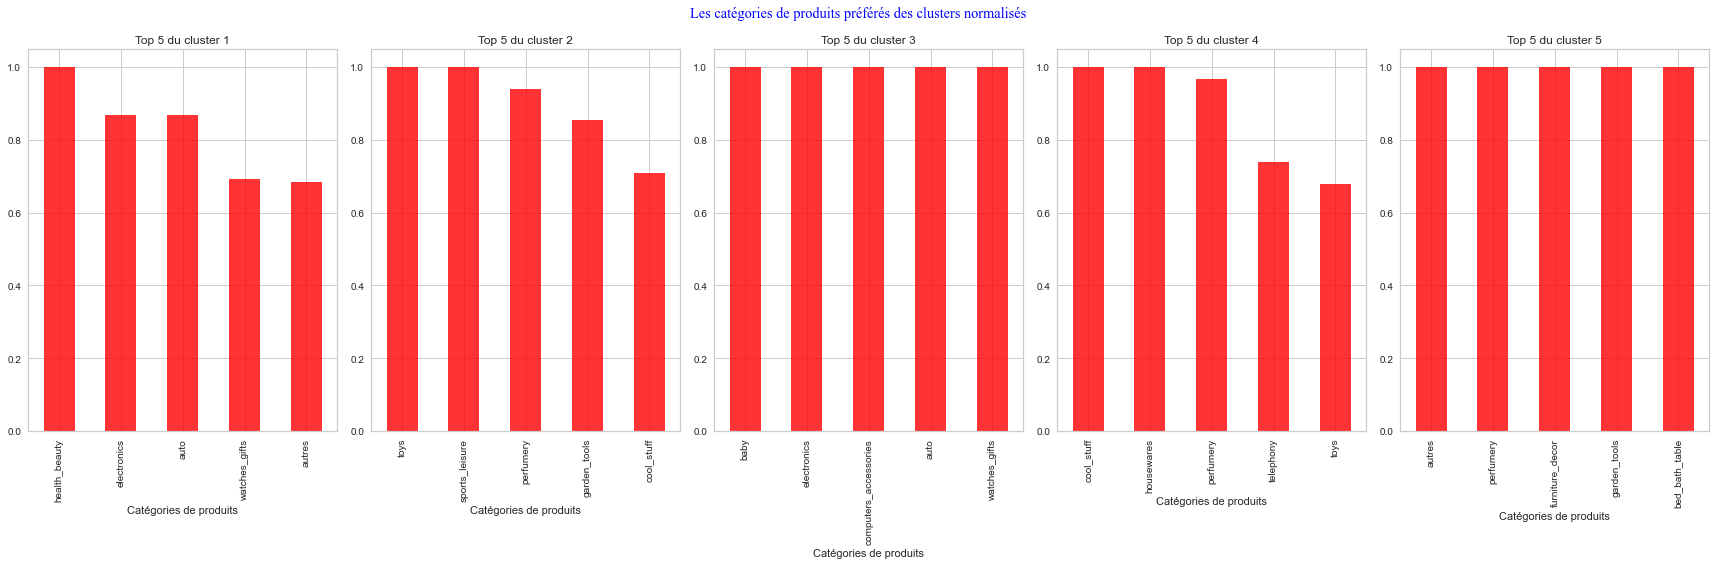

In [98]:
plt.figure(figsize=(24, 8))
plt.suptitle('Les catégories de produits préférés des clusters normalisés',
          fontdict=font_title)

plt.subplot(1,5,1)
plt.title("Top 5 du cluster 1")
cluster_1['cluster_1'][0:5].plot(
kind='bar',
color='red',
alpha=0.8,
xlabel="Catégories de produits")


plt.subplot(1,5,2)
plt.title("Top 5 du cluster 2")
cluster_2['cluster_2'][0:5].plot(
kind='bar',
color='red',
alpha=0.8,
xlabel="Catégories de produits")

plt.subplot(1,5,3)
plt.title("Top 5 du cluster 3")
cluster_3['cluster_3'][0:5].plot(
kind='bar',
color='red',
alpha=0.8,
xlabel="Catégories de produits")

plt.subplot(1,5,4)
plt.title("Top 5 du cluster 4")
cluster_4['cluster_4'][0:5].plot(
kind='bar',
color='red',
alpha=0.8,
xlabel="Catégories de produits")

plt.subplot(1,5,5)
plt.title("Top 5 du cluster 5")
cluster_5['cluster_5'][0:5].plot(
kind='bar',
color='red',
alpha=0.8,
xlabel="Catégories de produits")

plt.tight_layout()
plt.savefig("categorie_clusters.png") 

In [44]:
categories = ["watches_gifts", "toys", "telephony", "sports_leisure",
              "perfumery", "housewares", "health_beauty", "garden_tools",
              "furniture_decor", 'electronics', 'cool_stuff',
              'computers_accessories', 'bed_bath_table', 'baby', 'autres',
              'auto']

categories = X_clustering[categories]

X_clustering.drop(categories, axis=1, inplace=True)

In [45]:
X_clustering

,nb_commandes,temps_livraisons_mean,satisfaction_mean,fdp_total,price_total,moyen_payment_mean,versement_payment_mean,Year,total_items,mois_vente,order_total_delais
kmeans_cluster,,,,,,,,,,,
0,1.020940,11.671436,0.999677,21.720530,124.772657,1.017058,2.679767,2018.0,1.162139,3.512306,90.358443
1,1.038605,12.147224,0.998667,21.682996,126.698345,1.018065,2.928674,2017.0,1.190773,10.170679,248.860349
2,1.025369,21.921939,0.006730,26.328073,143.306738,1.016449,2.997244,2018.0,1.354084,3.163728,100.904282
3,1.039708,11.718223,0.998416,21.842519,127.189247,1.021485,3.088158,2017.0,1.201131,4.740567,413.061572
4,1.030260,20.203258,0.007328,25.661689,140.107969,1.021555,3.230122,2017.0,1.361106,8.317934,305.673391


### Les 5 clusters 

+ 1er : ce groupe a le panier moyen le moins cher avec une moyenne de 124,77 réal brésilien. Leurs paniers sont surtout constitués de produits de santé et de beautés. C'est le groupe qui va faire ses achats avec le moins de versement : 2,67 en moyenne. Ils sont très satisfaits de leur commande et avec un temps de livraison moyen de 11,67 jours.

+ 2eme : les clients ont passé leur commande dans le but d'offrir des cadeaux pour les fêtes de fin d'années. Les articles commandés sont des produits de loisir pour le sport ou/et des jouets. Le prix moyen du panier est de 126.69 réal brésilien. Ils ont échelonné les payements en moyenne en 2 ou 3 fois. Ils sont très satisfaits de leur commande avec un temps de livraison estimé en moyenne à 12 jours.

+ 3 eme : les clients de ce groupe sont les plus dépensiers, ils ont payé leur panier 143.30 réal brésilien pour des produits high-teck : électronique, des articles pour l'ordinateur, mais aussi des produits pour bébé et des cadeaux de montres. Ce choix de temps d'articles divers s'explique par le fait qu'ils sont insatisfaits des produits commandés ou bien le temps de livraison qui est d'en moyenne 21,9 jours le plus long des 5 groupes. Cela se répercute sur les avis laissés qui sont les plus mauvais.

+ 4 eme : les clients de ce groupe ont un panier moyen de 127,18 réal brésilien et très satisfait de leurs commandes avec un temps de livraison identique au premier groupe 11,7 jours. Les produits achetés sont des "cool_stuff" et des articles ménagers avec un échelonnement des payements en 3 fois.

+ 5 eme : ce groupe se rapproche du 3 ême dans la mesure où ils vont dépenser une somme conséquente 140.10 réal brésilien, mais les produits achetés sont des bricoles, des accessoires aussi bien pour la chambre, de la décoration que des outils de jardin. Ils sont très peu satisfait de leur commande, peut être dû à un temps de livraison long : 20 jours en moyenne. Ils vont payer leur commande en 3 fois en moyenne.

# Dataset Juillet
Nous allons réaliser les même transformation que nous avons faites sur le dataset principal pour avoir un sujet de comparaison idéal

In [53]:
df_ju.drop(['Unnamed: 0'], axis=1, inplace=True)
df_ju.drop(['review_score_mean', 'customer_unique_id',
           'retard_livraisons_mean',
            'products_per_order_mean'], axis=1, inplace=True)


categorical_features = list(df_ju.select_dtypes(
    exclude=['int64', 'float64', 'uint8']).columns)
categorical_features
categorical_features = df_ju[categorical_features]
df_ju.drop(categorical_features, axis=1, inplace=True)

In [54]:
df_ju.dropna(subset=['mois_vente'], axis=0, inplace=True)

In [55]:
juillet = df_ju.copy()
clustering_juillet = df_ju.copy()
jui = df_ju.copy()

In [56]:
df_juillet = scaler.transform(df_ju)

In [57]:
Kmeans_model.fit(df_juillet)

clustering_juillet = pd.DataFrame(
    df_juillet, index=df_ju.index, columns=df_ju.columns)
Kmeans_labels_jui = Kmeans_model.named_steps['kmeans'].labels_

clustering_juillet['kmeans_cluster'] = Kmeans_labels_jui

In [58]:
X_clust_sizes_jui = clustering_juillet.groupby(
    'kmeans_cluster').size().to_frame()
X_clust_sizes_jui.columns = ["KM_size"]
X_clust_sizes_jui

,KM_size
kmeans_cluster,
0,1141
1,472
2,1877
3,547
4,1659


In [59]:
silh_score_jui = metrics.silhouette_score(clustering_juillet,
                                          Kmeans_labels_jui, metric='euclidean')
print('Score de silhouette : %.3f ' % silh_score_jui)

Score de silhouette : 0.726 


In [60]:
target_jui = clustering_juillet['kmeans_cluster']

tsne_results_jui = tsne.fit_transform(clustering_juillet)

[t-SNE] Computing 136 nearest neighbors...
[t-SNE] Indexed 5696 samples in 0.000s...
[t-SNE] Computed neighbors for 5696 samples in 1.244s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5696
[t-SNE] Computed conditional probabilities for sample 2000 / 5696
[t-SNE] Computed conditional probabilities for sample 3000 / 5696
[t-SNE] Computed conditional probabilities for sample 4000 / 5696
[t-SNE] Computed conditional probabilities for sample 5000 / 5696
[t-SNE] Computed conditional probabilities for sample 5696 / 5696
[t-SNE] Mean sigma: 0.084827
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.935516
[t-SNE] KL divergence after 1000 iterations: 0.854484


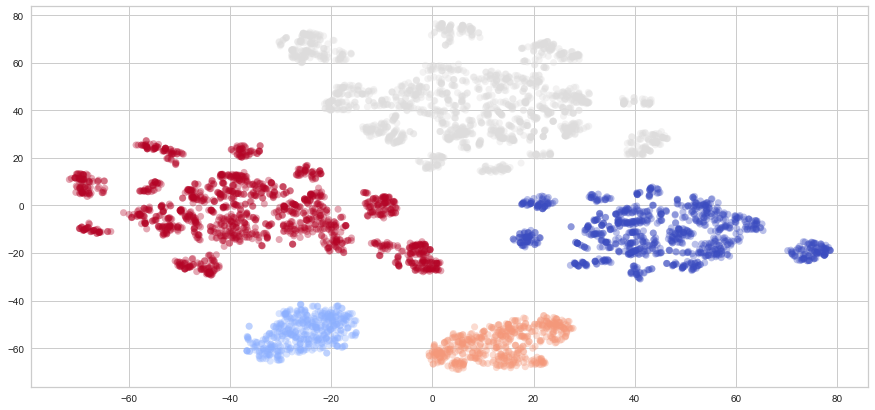

In [61]:
fig = plt.figure(figsize=[15, 7])
plt.scatter(tsne_results_jui[:, 0], tsne_results_jui[:, 1],  c=target_jui,
            cmap="coolwarm", edgecolor="None", alpha=0.35)

## Période d'Aout
Nous allons réaliser les même transformation que nous avons faites sur le dataset principal pour avoir un sujet de comparaison idéal

In [62]:
df_ao.drop(['Unnamed: 0'], axis=1, inplace=True)
df_ao.drop(['review_score_mean', 'customer_unique_id',
           'retard_livraisons_mean',
            'products_per_order_mean'], axis=1, inplace=True)


categorical_features = list(df_ao.select_dtypes(
    exclude=['int64', 'float64', 'uint8']).columns)
categorical_features
categorical_features = df_ao[categorical_features]
df_ao.drop(categorical_features, axis=1, inplace=True)

In [63]:
df_ao.dropna(subset=['mois_vente'], axis=0, inplace=True)

In [64]:
aout = df_ao.copy()
clustering_aout = df_ao.copy()
aou = df_ao.copy()

In [65]:
df_aout = scaler.transform(df_ao)

In [66]:
Kmeans_model.fit(df_aout)

clustering_aout = pd.DataFrame(
    df_aout, index=df_ao.index, columns=df_ao.columns)
Kmeans_labels_aout = Kmeans_model.named_steps['kmeans'].labels_

clustering_aout['kmeans_cluster'] = Kmeans_labels_aout

In [67]:
X_clust_sizes_aout = clustering_aout.groupby(
    'kmeans_cluster').size().to_frame()
X_clust_sizes_aout.columns = ["KM_size"]
X_clust_sizes_aout

,KM_size
kmeans_cluster,
0,1107
1,461
2,570
3,1790
4,1932


In [68]:
silh_score_aout = metrics.silhouette_score(clustering_aout,
                                           Kmeans_labels_aout, 
                                           metric='euclidean')
print('Score de silhouette : %.3f ' % silh_score_aout)

Score de silhouette : 0.712 


In [69]:
target_aout = clustering_aout['kmeans_cluster']
tsne_results_aout = tsne.fit_transform(clustering_aout)

[t-SNE] Computing 136 nearest neighbors...
[t-SNE] Indexed 5860 samples in 0.000s...
[t-SNE] Computed neighbors for 5860 samples in 1.183s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5860
[t-SNE] Computed conditional probabilities for sample 2000 / 5860
[t-SNE] Computed conditional probabilities for sample 3000 / 5860
[t-SNE] Computed conditional probabilities for sample 4000 / 5860
[t-SNE] Computed conditional probabilities for sample 5000 / 5860
[t-SNE] Computed conditional probabilities for sample 5860 / 5860
[t-SNE] Mean sigma: 0.079028
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.648422
[t-SNE] KL divergence after 1000 iterations: 0.811934


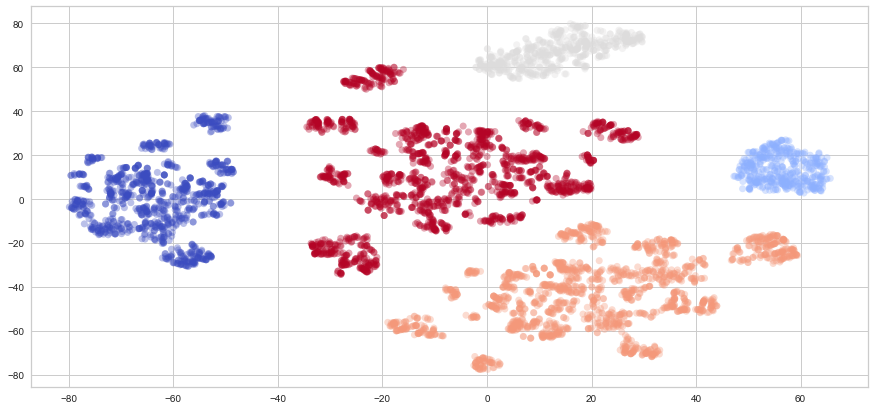

In [70]:
fig = plt.figure(figsize=[15, 7])
plt.scatter(tsne_results_aout[:, 0], tsne_results_aout[:, 1],  c=target_aout,
            cmap="coolwarm", edgecolor="None", alpha=0.35)

## Stabilité temporelle 

In [71]:
from sklearn.metrics import homogeneity_score, adjusted_rand_score, adjusted_mutual_info_score

In [72]:
kmeans_clusters_j = Kmeans_model.predict(df_juillet)

In [73]:
set(kmeans_clusters_j)

{0, 1, 2, 3, 4}

In [74]:
juillet_clust = clustering_juillet['kmeans_cluster'].values.reshape(-1)

In [75]:
ari_p_j = adjusted_rand_score(kmeans_clusters_j, juillet_clust)

In [76]:
print('ARI : %.3f ' % ari_p_j)

ARI : 0.954 


In [77]:
kmeans_clusters_a = Kmeans_model.predict(df_aout)

In [78]:
aout_clust = clustering_aout['kmeans_cluster'].values.reshape(-1)

In [79]:
ari_p_a = adjusted_rand_score(kmeans_clusters_a, aout_clust)

In [80]:
print('ARI : ', ari_p_a)

ARI :  1.0


Sur les deux mois la prédiction du modèle général est excellente on peut aller au delà du mois d’aout 
